# Final Capstone: Brixc
### Jordan Muskitta

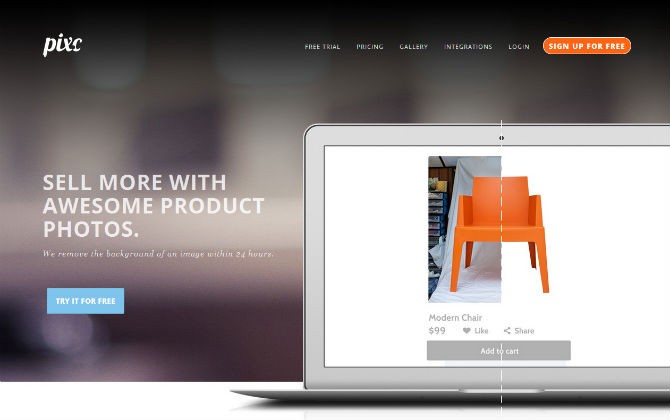

### Introduction

Brixc is a SAAS company, that was founded by Molly Maardew an Australian eCommerce entrepreneur. Brixc allows customers to access wholesale prices when it comes to their photo editing needs through bulk ordering pricing. 

Brixc is addressing an \\$11.3 billion e-commerce SaaS market that is made of over 25 million businesses and is expanding its product offering using artificial intelligence and machine learning. With the transition of brick and mortar retail, this industry is expected to grow to \\$27 trillion by 2020.

Brixc is fully integrated with eCommerce platforms such as Shopify and Woocommerce. Making it really simple to link with customers existing photos and shops.

Like many SAAS companies, the metrics for success are somewhat convoluted. How should we measure Brixc goals? Through revenue growth? Customer churn and growth?

This notebook will attempt to analyse metrics that are petinent to gauging Brixc's current and future profitability. These metrics are customer churn, customer lifetime value, promotional efficacy and revenue metrics in absolute terms.

### Goals and Criteria For Success

Because this will be one of the first times that data analysis has been performed on Brixc's data. The goals and criteria for this project will remain rather broad. Perhaps criteria for success in future projects can be more refined and specific.

- Find one subscription insight
- Find one growth/revenue insight
- Find customer churn rate
- Find customer lifetime value 
- Deliver analysis by the due date


In [313]:
#Import the libraries: 
import warnings
warnings.filterwarnings('ignore')

#Basic  libraries: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

#Surival analysis and customer value libraries:
from lifelines import KaplanMeierFitter

#Customer Lifetime Value: 
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter 
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_probability_alive_matrix



### Part 1: SQL Queries and Database Overview

The first part of this project involved the use of DBeaver and MySQL in order to filter and extract the data that we will use to analyze with Python. The database for Brixc is quite large with over 200 tables. It is understood that Brixc has had many developer and database admistrators over the course of it's lifetime. The databse doesn't seem to be very organised with many columns and tables that don't seem to connect with one and other. However, the data that is stored in the tables that are relevant to our analysis seem to be rather complete. 

The tables that will be extracted in the course of this project are as follows:

* AccountCredits

* CreditTransactions

* PaymentSubscriptionType

* Subscriptions

* OrderImagePrices

* Orders 


A full data dictionary is provided below: 

In [8]:
#import data dictionary:

data_dictionary = pd.read_csv('data/data_dictionary.csv')
data_dictionary

Table Name  Column Count Row Count  \
0      AccountCredits             6   108,688   
1  CreditTransactions            32   413,443   
2              Orders            36    124416   
3       Subscriptions            17    131242   
4   SubscriptionTypes            20        17   

                                            Columns           Primary Key  \
0  accountCreditId\ncurrentTotal\ncurrentBonus\nc...      accountCreditId   
1  creditTransactionId\ncreditAmount\ncreatedAt\n...  creditTransactionId   
2  orderId\nstatus\ncustomerId\ntemplateId\nuserI...              orderId   
3  subscriptionId\ncreatedAt\nupdatedAt\naccountC...       subscriptionId   
4  subscriptionTypeId\ntitle\ncreatedAt\nupdatedA...       subscriptionId   

                          Foreign Key   
0                           customerId  
1  orderId, invoiceId, accountCreditId  
2                           customerId  
3  accountCreditId, subscriptionTypeId  
4                                  NaN

Most of the tables joins that are going to be performed in this project will be LEFT OUTER JOINs. This is because we don't want to exclude any null values and want to keep as much data as possible and then clean within a Python environment.  

Below are the queries that were used in order to extract the data from the database: 

**For Python Analysis:** 
```mysql 
#get creditTransaction information for survival, tables are pre joined
SELECT ct.createdAt, ct.amount, ct.accountCreditId, ct.creditsBefore, ct.creditsAfter, 
ct.creditAmount, ct.bonusBefore ,ct.bonusAfter, ct.bonusAmount, s.subscriptionTypeId, s.active, ac.customerId, s.isCanceled, c2.isDeleted  
FROM CreditTransactions ct LEFT OUTER JOIN Subscriptions s ON ct.accountCreditId = s.accountCreditId 
LEFT OUTER JOIN AccountCredits ac ON s.accountCreditId = ac.accountCreditId 
LEFT OUTER JOIN Customers c2 ON ac.customerId = c2.customerId 

#this table was only used as a refernce to orders joined table
SELECT ct.createdAt ,Orders.orderId, ct.orderId , Orders.customerId FROM Orders
LEFT JOIN Customers ON Orders.customerId = Customers.customerId
LEFT JOIN CreditTransactions ct ON Orders.orderId = ct.orderId
ORDER BY 1 DESC; 
```

**For Tableau Visualisations:**

```mysql
#get invoice information
SELECT * FROM Invoices i
```
```mysql
#get creditTransaction table
SELECT * FROM CreditTransactions ct

#get creditTransactions of member types only
SELECT * FROM CreditTransactions ct LEFT JOIN Subscriptions s ON ct.accountCreditId  = s.accountCreditId 
WHERE s.subscriptionTypeId <> 8;

#get grossCost information 
SELECT oip.createdAt,o.customerId, oip.amount AS grossCost FROM OrderImagePrices oip 
JOIN Orders o ON oip.orderId = o.orderId 

#get grossRevenue information
SELECT ct.createdAt, ac.customerId, ct.amount AS GrossRevenue FROM CreditTransactions ct 
LEFT JOIN AccountCredits ac ON ct.accountCreditId = ac.accountCreditId

#get the bonus account balances (last day)
SELECT ct2.createdAt, t1.lastDate,t1.customerId,ct2.bonusAfter, s.subscriptionTypeId, s.isCanceled FROM CreditTransactions ct2 
INNER JOIN 
(SELECT MAX(ct.createdAt)AS lastDate, ac.customerId FROM CreditTransactions ct 
LEFT JOIN AccountCredits ac ON ct.accountCreditId = ac.accountCreditId 
GROUP BY ac.customerId) AS t1 ON ct2.createdAt = t1.lastDate
LEFT OUTER JOIN Subscriptions s ON ct2.accountCreditId = s.accountCreditId
GROUP BY customerId 
ORDER BY 4 DESC

```



In [9]:
#import the datasets: 

df = pd.read_csv('data/acc_cred3.csv')
df2 = pd.read_csv("data/acc_cred3.csv")
df_rev = pd.read_csv("data/revenue2.csv")
df_cost = pd.read_csv("data/costs.csv")

### Part 2: Preprocessing

The data that has been extracted from the SQL server is relatively messy as it is raw data. In this report we will perform some common preprocessing task in order to prepare the data for the analysis stage of the report.

**Preprocessing that will be performed:**
- Checking for nulls
- Imputing nulls
- Converting columns into appropriate dtypes


In [30]:
#check for null values in all the dataframes:

print("For df:")
print(df.isnull().sum())
print("\ndf2 is the same as df")
print("\nFor df_rev:")
print(df_rev.isnull().sum())
print("\nFor df_cost:")
print(df_cost.isnull().sum())

For df:
createdAt               0
amount                  0
accountCreditId         0
creditsBefore           0
creditsAfter            0
creditAmount            0
bonusBefore             0
bonusAfter              0
bonusAmount             0
subscriptionTypeId      0
active                163
customerId              0
isCanceled              0
isDeleted               0
dtype: int64

df2 is the same as df

For df_rev:
createdAt       0
customerId      0
GrossRevenue    0
dtype: int64

For df_cost:
createdAt     0
customerId    5
grossCost     0
dtype: int64


### Impute? A Case for Imputation

As one can see by the data presented above. There are some columns in the df, df2 and df_rev that contain null values that we need to address before moving to the data analysis stage of this report. 

**For customerId:**

Given that 8511/~493356 is ~0.0172512344 or ~1.725% and given that this is timeseries data (important to keep dates as complete as possible), we shall impute the null values in the customerId column with values that are out of the scope/range. This value will be -99. 

**For subscriptionId:**

We will also impute the median value for the null values in subscriptionTypeId to return the highest re-occuring value. Given that the sum of the null values in this column, it can be safely assumed that imputation will have no significant impact on the analysis later on. 

**For isDeleted:**

We will need to impute values into the isDeleted column because our survival analysis requires a death event. The value that will be imputed is the median. This is because this column is a boolean/diochomatous value. The median for isDeleted is 0, therefore we will impute this values inplace. 

**For isCanceled:**

We must impute for the column isCanceled for the same reasons as isDeleted. The median for isCanceled is 0 as well. 


In [17]:
#check the shapes or each df in order to see the general size: 

print('Shape for df:')
print(df.shape)
print('\nShape for df_rev:')
print(df_rev.shape)
print('\nShape for df_cost:')
print(df_cost.shape)



Shape for df:
(493356, 14)

Shape for df_rev:
(420525, 3)

Shape for df_cost:
(943077, 3)


In [52]:
#impute and dealing with null values: 

#for customerId
df['customerId'].fillna(-99, inplace= True)
df2['customerId'].fillna(-99, inplace= True)
df_rev['customerId'].fillna(-99, inplace= True)
df_cost['customerId'].fillna(-99, inplace= True)


#for subscriptionId
df['subscriptionTypeId'].fillna(8, inplace= True)
df2['subscriptionTypeId'].fillna(8, inplace= True)


#for isDeleted: 
df['isDeleted'].fillna(0, inplace= True)
df2['isDeleted'].fillna(0, inplace= True)

#for isCanceled: 
df['isCanceled'].fillna(0, inplace= True)
df2['isCanceled'].fillna(0, inplace= True)

#for active:

df['active'].fillna(0, inplace= True)
df2['active'].fillna(0, inplace= True)

#for createdAt: 
df['createdAt'].fillna(method='bfill', inplace = True)
df2['createdAt'].fillna(method='bfill', inplace = True)


#double-check that the imputation worked: 

print("For df:")
print(df.isnull().sum())

For df:
createdAt             0
amount                0
accountCreditId       0
creditsBefore         0
creditsAfter          0
creditAmount          0
bonusBefore           0
bonusAfter            0
bonusAmount           0
subscriptionTypeId    0
active                0
customerId            0
isCanceled            0
isDeleted             0
dtype: int64


In [38]:
#check for dtypes for each table:

print('Datatypes for df:')
print(df.dtypes) 

print('\nDatatypes for df2:')
print(df2.dtypes) 

print('\nDatatypes for df_rev:')
print(df_rev.dtypes) 

print('\nDatatypes for df_cost: ')
print(df_cost.dtypes)

Datatypes for df:
createdAt              object
amount                float64
accountCreditId         int64
creditsBefore           int64
creditsAfter            int64
creditAmount            int64
bonusBefore             int64
bonusAfter              int64
bonusAmount             int64
subscriptionTypeId    float64
active                float64
customerId              int64
isCanceled            float64
isDeleted             float64
dtype: object

Datatypes for df2:
createdAt              object
amount                float64
accountCreditId         int64
creditsBefore           int64
creditsAfter            int64
creditAmount            int64
bonusBefore             int64
bonusAfter              int64
bonusAmount             int64
subscriptionTypeId    float64
active                float64
customerId              int64
isCanceled            float64
isDeleted             float64
dtype: object

Datatypes for df_rev:
createdAt        object
customerId        int64
GrossRevenue    float64

### Datatype Conversion

Why do we need to convert the datatypes? Some of the datatypes need to be converted sometimes float datatypes can have values in the n-th decimal spot that can cause problems when grouping and segmenting a data frame. All id's and typeId's must be converted into an whole integer. Boolean/dichotomous columns should also be converted to a whole integer datatype for the same reason as the Id columns. 

Also all the createdAt columns must be converted into a datatime object in order to make datetime calculations easier in Python.   

In [57]:
#primary key and foreign key conversion: 
#for customerId: 
df['customerId'] = df['customerId'].astype('int64')    
df2['customerId'] = df2['customerId'].astype('int64')  
df_rev['customerId'] = df_rev['customerId'].astype('int64')
df_cost['customerId'] = df_cost['customerId'].astype('int64')

#for subscriptionTypeId: 
df['subscriptionTypeId'] = df['subscriptionTypeId'].astype('int64')    
df2['subscriptionTypeId'] = df2['subscriptionTypeId'].astype('int64') 

#for boolean columns: 
df['isCanceled'] = df['isCanceled'].astype('int64')    
df2['isCanceled'] = df2['isCanceled'].astype('int64') 
df['isDeleted'] = df['isDeleted'].astype('int64')    
df2['isDeleted'] = df2['isDeleted'].astype('int64')
df['active'] = df['active'].astype('int64')    
df2['active'] = df2['active'].astype('int64')

#convert into datetime format 
df['createdAt'] = pd.to_datetime(df["createdAt"],errors='coerce')
df2['createdAt'] = pd.to_datetime(df2["createdAt"],errors='coerce')
df_rev['createdAt'] = pd.to_datetime(df_rev["createdAt"],errors='coerce')
df_cost['createdAt'] = pd.to_datetime(df_cost["createdAt"],errors='coerce')

In [58]:
#double-check for dtypes for each table:

print('Datatypes for df:')
print(df.dtypes) 

print('\nDatatypes for df2:')
print(df2.dtypes) 

print('\nDatatypes for df_rev:')
print(df_rev.dtypes) 

print('\nDatatypes for df_cost: ')
print(df_cost.dtypes)

Datatypes for df:
createdAt             datetime64[ns]
amount                       float64
accountCreditId                int64
creditsBefore                  int64
creditsAfter                   int64
creditAmount                   int64
bonusBefore                    int64
bonusAfter                     int64
bonusAmount                    int64
subscriptionTypeId             int64
active                         int64
customerId                     int64
isCanceled                     int64
isDeleted                      int64
dtype: object

Datatypes for df2:
createdAt             datetime64[ns]
amount                       float64
accountCreditId                int64
creditsBefore                  int64
creditsAfter                   int64
creditAmount                   int64
bonusBefore                    int64
bonusAfter                     int64
bonusAmount                    int64
subscriptionTypeId             int64
active                         int64
customerId             

### Part 3 :Analysis
### Survival Analysis With Lifelines Library

One core metric that will be focused on in this report as a gauge for Brixc success' and viability as a company is it's customer churn rate. Instead of caluclating the churn rate using the standard formula, this report will use the Lifelines Python library in order to perform survival analysis on the subscribers. Survival analysis is a branch of statistics that measures the probability of an event occuring accross a time period. Survival analysis was originally used in the medical fields to calculate survival rates of patients. 

**General definition:** 

What is customer churn? Essentially customer churn is the amount of customers that has stopped using your product given a certain time-period. Customer churn is an important metric to consider for any subscription based business because it can show the business' level of customer retention and perhaps help traingulate problems in the business operations of pricing model that could be affecting the overall success of the business. 

**Basic calculation:** 

To calculate customer churn rate, designate a time period and tally up the total number of customers you've acquired and the number of customers who churned during that time period. Then, divide the number of customers who churned by the total number of customers acquired, and multiply that decimal by 100% to calculate your churn rate.


**Lifelines Python Library:**

We will be using the Lifelines Python Library in order to calculate the churn rate of the subscribed customers. Specifically, we will be using the Kaplan Meier Model.  

For more documentation of the lifelines library please visit: https://lifelines.readthedocs.io/en/latest/

**Steps needed to perform Lifelines Survival Analysis:**

- Find the first and last transaction for a given customer
- Calculate the time difference in a chosen unit of time (days)
- Segment according to subscriptionTypeId and then plot results



In [94]:
#make a copy of the dfs:

df_copy = df.copy()
df2_copy = df2.copy()
dfrev_copy = df_rev.copy()
dfcost_copy = df_cost.copy()

#find first_trans and last_trans
#finding the first instance of a customer credit transaction
df_full = df_copy.sort_values(['customerId','createdAt']).drop_duplicates(subset='customerId')

#finding the last instance of a customer credit transaction

df_last = df_copy.sort_values(['customerId','createdAt']).drop_duplicates(subset='customerId', keep='last')

In [95]:
#add the last date to the dataframe containing the first date (df_full)

df_full['finalTransDate'] = df_last['createdAt'].values

#calculate the number of days that are between the first and last date and add to seperate column

df_full['dayDifference'] = (df_full['finalTransDate'] - df_full['createdAt']).dt.days

In [82]:
#shows the creditTransactions segemented into (subscriptionTypeId). NOT UNIQUE

df_copy['subscriptionTypeId'].value_counts()


8     422088
2      34474
7      20752
15      6506
3       2932
16      2920
11      2645
17       662
12       265
13        54
18        44
19        11
10         3
Name: subscriptionTypeId, dtype: int64

In [101]:
#shows the creditTransactions segemented into (subscriptionTypeId). Shows unique customerId


grouped = df_copy.groupby(by = 'subscriptionTypeId')['customerId'].nunique()
grouped.sort_values()

subscriptionTypeId
10         1
19         5
13         6
18        14
3         24
12        45
17       197
11       208
7        300
16       863
15      2078
2       5095
8     105179
Name: customerId, dtype: int64

In [104]:
#find first and last date

sort_id = df_copy.groupby('customerId')['createdAt'].agg(['first','last']).reset_index()

In [107]:
#find the difference in days between the first and last

sort_id['dayDifference'] = (sort_id['last'] - sort_id['first']).dt.days

In [125]:
#merge subscription type

sort_merge = pd.merge(sort_id,df_copy[['customerId','subscriptionTypeId', 'isCanceled']],on='customerId', how='left')

In [129]:
#boolean filter to show only member subscription type

m_only = sort_merge[sort_merge['subscriptionTypeId'] != 8]

In [133]:
#drop duplicates in the customerId column to show only unique subscriptions 

m_drop = m_only.drop_duplicates(subset=['customerId'])

In [139]:
#double check

m_drop['subscriptionTypeId'].value_counts()

2     5095
15    2026
16     643
7      283
11     192
17     108
12      37
3       24
18      14
19       5
13       4
10       1
Name: subscriptionTypeId, dtype: int64

In [150]:
#declare the T's and C's
#compare the survival between the two largest segments of member segment

kmf= KaplanMeierFitter()

#declare normal member: 
member_T = m_drop[m_drop['subscriptionTypeId'] == 7]['dayDifference']
member_C = m_drop[m_drop['subscriptionTypeId'] == 7]['isCanceled']

#declare photo resize pro: 
prp_T = m_drop[m_drop['subscriptionTypeId'] == 2]['dayDifference']
prp_C = m_drop[m_drop['subscriptionTypeId'] == 2]['isCanceled']

#declare resize basic 
rb_T = m_drop[m_drop['subscriptionTypeId'] == 15]['dayDifference']
rb_C = m_drop[m_drop['subscriptionTypeId'] == 15]['isCanceled']

#declare resize pro 
rp_T = m_drop[m_drop['subscriptionTypeId'] == 16]['dayDifference']
rp_C = m_drop[m_drop['subscriptionTypeId'] == 16]['isCanceled']

#declare resize basic 
rpp_T = m_drop[m_drop['subscriptionTypeId'] == 17]['dayDifference']
rpp_C = m_drop[m_drop['subscriptionTypeId'] == 17]['isCanceled']

Populating the interactive namespace from numpy and matplotlib


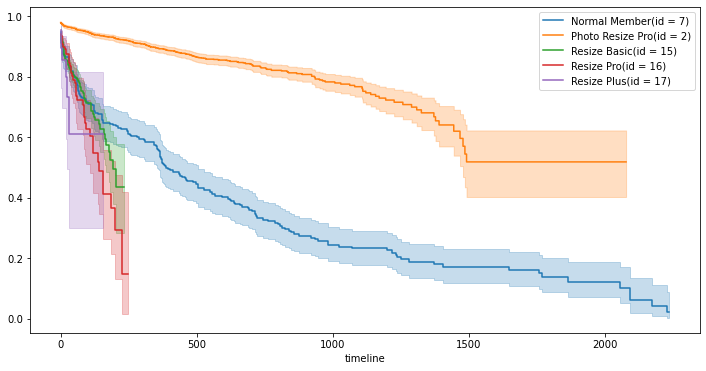

In [240]:
#for member segment
kmf.fit(member_T,member_C, label="Normal Member(id = 7)")
%pylab inline
figsize(12,6)
ax = kmf.plot()

#for photo resize pro
kmf.fit(prp_T, prp_C, label="Photo Resize Pro(id = 2)")
ax = kmf.plot(ax=ax)

#for resize basic
kmf.fit(rb_T, rb_C, label="Resize Basic(id = 15)")
ax = kmf.plot(ax=ax)

#for resize pro
kmf.fit(rp_T, rp_C, label="Resize Pro(id = 16)")
ax = kmf.plot(ax=ax)

#for resize plus
kmf.fit(rpp_T, rpp_C, label="Resize Plus(id = 17)")
ax = kmf.plot(ax=ax)

plt.savefig('data/all_kmf.png')

This is our survival regression for lines for the main subscription types that Brixc has to offer. The lines that only end around the ~250 day mark are the new product offerings that were introduced in 2019. Let's look at these three graphs in more detail to see their survival rate at a better scale. 

In [1]:
kmf2 = KaplanMeierFitter()
#for resize basic
kmf2.fit(rb_T, rb_C, label="Resize Basic(id = 15)")
%pylab inline
figsize(12,6)
ax = kmf2.plot()

#for resize pro
kmf2.fit(rp_T, rp_C, label="Resize Pro(id = 16)")
ax = kmf2.plot(ax=ax)

#for resize plus
kmf2.fit(rpp_T, rpp_C, label="Resize Plus(id = 17)")
ax = kmf2.plot(ax=ax)

plt.savefig('data/kmf151617.png')

NameError: name 'KaplanMeierFitter' is not defined

Let's see the survival regression for the older/legacy membership subscriptions: 


Populating the interactive namespace from numpy and matplotlib


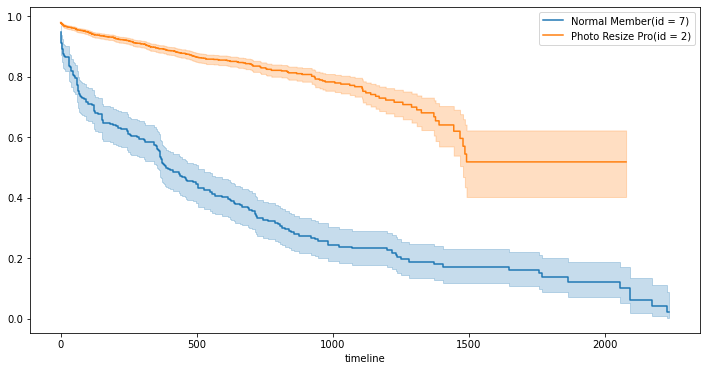

In [242]:
kmf3 = KaplanMeierFitter()

#for member segment
kmf3.fit(member_T,member_C, label="Normal Member(id = 7)")
%pylab inline
figsize(12,6)
ax = kmf3.plot()

#for photo resize pro
kmf3.fit(prp_T, prp_C, label="Photo Resize Pro(id = 2)")
ax = kmf3.plot(ax=ax)

plt.savefig('data/kmf72.png')

### Findings

As we can see by the graph above, the standard membership subscription has a much higher rate of decline than the photo resize pro subscription type. What are some reasons for the dramatic difference between the two subscription survival rates? One major difference between the two subscriptions is the price, Photo Resize Pro is only \\$19/month while the Pixc member subscription is \\$79/month. 

### Limitations To Survival Analysis

We know from exploring the data that the majority of Brixc's customers come from pay-as-you-go/non-subscribed customers. Below we can see the value counts of the different subscription types. Survival analysis can't be performed on the the unsubscribed component of the customer base because in order to perform a survival analysis there needs to be a death event. Because unsubscribed customers never joined there's also no recorded cancellation.

Also another fact to consider is how to handle if a customer has unsubsribed and then resubbed. 



### Customer lifetime value

One important metric for any ecommerce/SAAS company is customer lifetime value (CLV). Before we can calculate CLV, we should explore a basic definition of what is is and why it is used.  Customer Lifetime Value is underpinned by stochastical theory and calculation. Due to limited time, I have only scratched the surface of these theoretical ideas and calculations.

**General definition:** 

*\"Customer lifetime value is the metric that indicates the total revenue a business can reasonably expect from a single customer account. It considers a customer's revenue value, and compares that number to the company's predicted customer lifespan. Businesses use this metric to identify significant customer segments that are the most valuable to the company.\"* <sub>https://blog.hubspot.com/service/how-to-calculate-customer-lifetime-value</sub>

**Basic calculation:** 

*\"To calculate customer lifetime value you need to calculate average purchase value, and then multiply that number by the average purchase frequency rate to determine customer value. Then, once you calculate average customer lifespan, you can multiply that by customer value to determine customer lifetime value.\"* <sub>https://blog.hubspot.com/service/how-to-calculate-customer-lifetime-value</sub>

**Lifetimes Python Library:**

The Lifetimes Python Library makes this process relatively simple once shaping and format of the data has been performed. The method that is being performed in this report was taken from the Lifetimes documentation.

Link to documentation: https://lifetimes.readthedocs.io/en/latest/Quickstart.html

Link to math theory that Lifetimes is built on: http://www.brucehardie.com/notes/025/gamma_gamma.pdf


In [165]:
#make a summary for each year ending of the dataset in order to shape into the proper format
#use the summary module that comes with lifetimes

summary = summary_data_from_transaction_data(df2_copy, 'customerId', 'createdAt', observation_period_end='2020-01-01')
summary_2014 = summary_data_from_transaction_data(df2_copy, 'customerId', 'createdAt', observation_period_end='2014-01-01')
summary_2015 = summary_data_from_transaction_data(df2_copy, 'customerId', 'createdAt', observation_period_end='2015-01-01')
summary_2016 = summary_data_from_transaction_data(df2_copy, 'customerId', 'createdAt', observation_period_end='2016-01-01')
summary_2017 = summary_data_from_transaction_data(df2_copy, 'customerId', 'createdAt', observation_period_end='2017-01-01')
summary_2018 = summary_data_from_transaction_data(df2_copy, 'customerId', 'createdAt', observation_period_end='2018-01-01')

In [166]:
#Let's have a look at what the data contains:

print(summary_2014)
print(summary_2015)
print(summary_2016)
print(summary_2017)
print(summary_2018)
print(summary)

            frequency  recency      T
customerId                           
1511              0.0      0.0   98.0
1557              0.0      0.0  115.0
1562              0.0      0.0  112.0
1567              0.0      0.0  110.0
1583              0.0      0.0   93.0
1584              0.0      0.0   92.0
1587              0.0      0.0   90.0
1600              0.0      0.0   84.0
1609              0.0      0.0   82.0
1610              0.0      0.0   82.0
1612              0.0      0.0   81.0
1643              0.0      0.0   69.0
1657              0.0      0.0   64.0
1658              0.0      0.0   64.0
1677              0.0      0.0   60.0
1688              0.0      0.0   57.0
1698              0.0      0.0   54.0
1728              0.0      0.0   48.0
1740              0.0      0.0   43.0
1745              0.0      0.0   42.0
1761              0.0      0.0   37.0
1766              0.0      0.0   37.0
1806              0.0      0.0   28.0
1844              0.0      0.0   22.0
1853        

In [290]:
#use the entire observation period (summary-until 2021)
#filter for frequency that are > 0 
#make one and two year comparisons of the data, make variables summary_oney and summary_twoy

summary_filtered = summary[summary['frequency']>0]

summary_oney = summary_filtered[summary_filtered['T']<365]

summary_twoy = summary_filtered[summary_filtered['T']<730]

In [291]:
#fit the model

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf.summary)

bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_oney['frequency'], summary_oney['recency'], summary_oney['T'])
print(bgf2.summary)

bgf3 = BetaGeoFitter(penalizer_coef=0.0)
bgf3.fit(summary_twoy['frequency'], summary_twoy['recency'], summary_twoy['T'])
print(bgf3.summary)

             coef  se(coef)  lower 95% bound  upper 95% bound
r        0.916521  0.007006         0.902789         0.930253
alpha  348.313633  3.276670       341.891361       354.735906
a        0.005248  0.001067         0.003156         0.007340
b        0.009779  0.002005         0.005848         0.013709
            coef  se(coef)  lower 95% bound  upper 95% bound
r       1.077615  0.038112         1.002915         1.152315
alpha  36.937028  2.056056        32.907158        40.966897
a       0.753999  0.047110         0.661664         0.846334
b       0.326013  0.025048         0.276918         0.375107
             coef  se(coef)  lower 95% bound  upper 95% bound
r        1.708096  0.027444         1.654307         1.761886
alpha  358.819536  7.037195       345.026634       372.612438
a        0.052955  0.009668         0.034006         0.071904
b        0.031631  0.005811         0.020242         0.043021


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

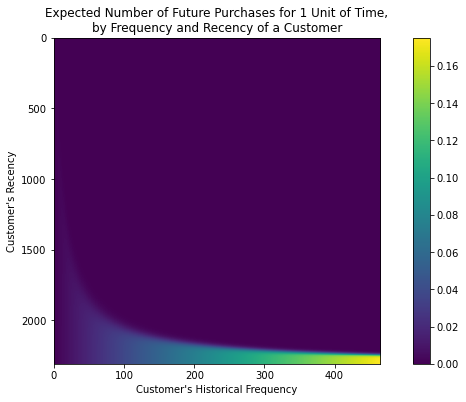

In [170]:
#I changed problem question, so these next two graphs aren't needed entirely but I though it would be good to see an example of more modules in lifetimes
#The older the customer the more frequency (kinda intuitive...)

plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

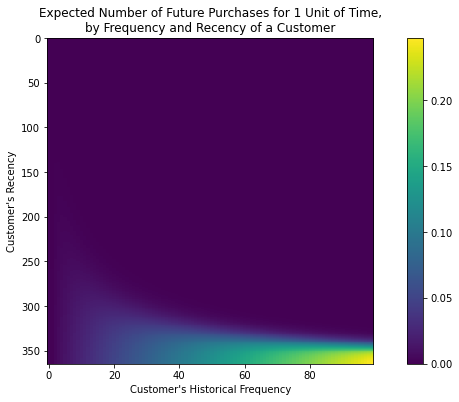

In [287]:
#almost no expected repeat purchases for under 300days 

plot_frequency_recency_matrix(bgf2)

In [172]:
#group by customerId and find the mean amount for every entry

grouped_mean = df2_copy.groupby(by = 'customerId')['amount'].mean()

In [173]:
grouped_mean 

customerId
-99        0.00141
 1         0.00000
 2         1.00000
 3         0.00000
 4         0.00000
            ...   
 117437    0.00000
 117438    0.00000
 117439    0.00000
 117440    0.00000
 117441    0.00000
Name: amount, Length: 105198, dtype: float64

In [306]:
#merged summary and amount series
merged_summary = summary_filtered.merge(grouped_mean, how = 'inner', left_on = summary_filtered.index, right_on = 'customerId')
merged_summary

#make sure theres no non-positive amounts
non_negative_amounts = merged_summary[merged_summary['amount']>0]

#set the customerId to index
non_negative_amounts.set_index('customerId', inplace = True)
non_negative_amounts

frequency  recency       T     amount
customerId                                       
-99             279.0   1586.0  1586.0   0.001410
 2                4.0   1532.0  1685.0   1.000000
 7                3.0   1533.0  1686.0   4.285714
 8                3.0   1486.0  1639.0   7.714286
 9               15.0   1533.0  1686.0   1.371429
...               ...      ...     ...        ...
 80384            1.0      1.0     3.0  14.992500
 80435            1.0      1.0     2.0   5.000000
 80503            1.0      1.0     1.0   2.200000
 98807            9.0    897.0  1050.0  19.118800
 106043          27.0    925.0  1078.0   4.480135

[8244 rows x 4 columns]

In [307]:
#Declare the fitter and fit the model

ggf = GammaGammaFitter(penalizer_coef = 0)

ggf.fit(non_negative_amounts['frequency'],
        non_negative_amounts['amount'])

<lifetimes.GammaGammaFitter: fitted with 8244 subjects, p: 0.48, q: 1.80, v: 20.80>

In [308]:
#Output the predicted customer lifetime value

print(ggf.conditional_expected_average_profit(
        non_negative_amounts['frequency'],
        non_negative_amounts['amount']
    ))

customerId
-99         0.075510
 2          4.380524
 7          7.220435
 8          9.427055
 9          2.483053
             ...    
 80384     13.449061
 80435      9.694313
 80503      8.642195
 98807     18.090542
 106043     4.946151
Length: 8244, dtype: float64


In [329]:
#Find the average transaction size

print("Expected conditional average spend: %s, Average spend: %s" % (
    ggf.conditional_expected_average_profit(
        non_negative_amounts['frequency'],
        non_negative_amounts['amount']
    ).mean(),
    non_negative_amounts[non_negative_amounts['frequency']>0]['amount'].mean()
))

Expected conditional average spend: 11.246852075511823, Average spend: 10.042347795374168


Text(0.5, 1.0, 'Distribution of Customer Lifetime Values')

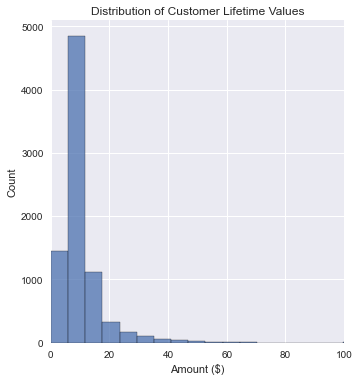

In [356]:
#Make a graph showing the distrobution of the customer lifetime value

cust_val = ggf.conditional_expected_average_profit(
        non_negative_amounts['frequency'],
        non_negative_amounts['amount']
    )


sns.displot(cust_val, bins = 100)
figsize(12,6)
plt.style.use('seaborn')
plt.xlim(0,100)
xlabel('Amount ($)')
plt.title('Distribution of Customer Lifetime Values')

Text(0.5, 1.0, 'Distribution of Customer Lifetime Values')

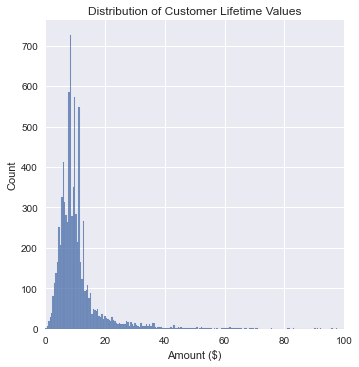

In [368]:
#try another style

# cust_df = pd.DataFrame(cust_val)

# sns.displot(cust_df, x=cust_df[0])
# figsize(12,6)
# plt.style.use('seaborn')
# plt.xlim(0,100)
# xlabel('Amount ($)')
# plt.title('Distribution of Customer Lifetime Values')

As you can see the Customer Lifetime Value distribution is heavily skewed with most of the values falling \\$1-\\$10. This is reinforced by the calculated average spend per transaction of \\$10.04, that was calculated before this.

### Recency, Frequency and Monetary Amount (RFM)

This concept was coined in marketing field. It is a marketing analysis tool that is used to identify a company's best/most viable customers by the use of certain metrics. 

The RFM model is based on three quantitative factors:

- Recency: How recently a customer has made a purchase
- Frequency: How often a customer makes a purchase
- Monetary Value: How much money a customer spends on purchases

We can use the RFM model with Lifeitimes in order to find many important metrics such as the probabilities of repeat transaction and probability of a customer being alive (this is essentially a survival analysis based of recency and frequency). 

So let's have a look at both the probability of repeat transactions and the probability of a customer being alive below. 


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

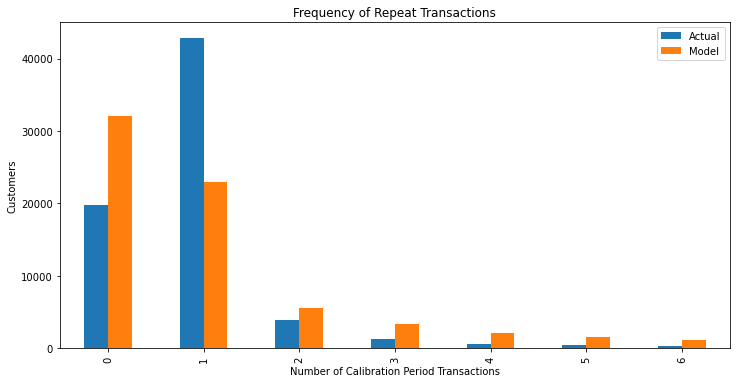

In [342]:
#show period transactions actual vs model
#this will show us the predicted frequency of purchase against the actual

plot_period_transactions(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

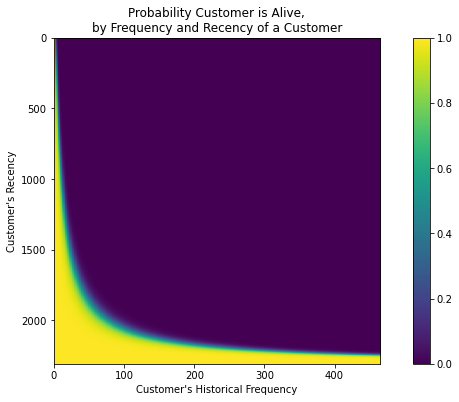

In [275]:
#use lifetimes method of plot_probability_alive_matrix to plot probability of alive given recency and frequency

plot_probability_alive_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

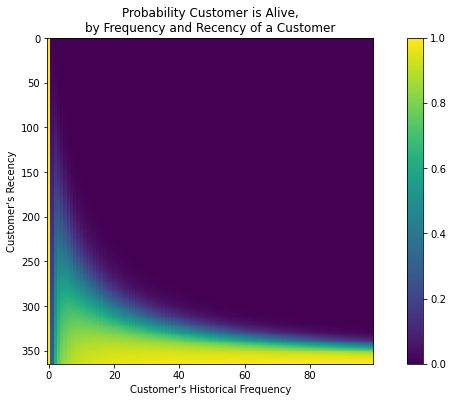

In [288]:
#for one year

plot_probability_alive_matrix(bgf2)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

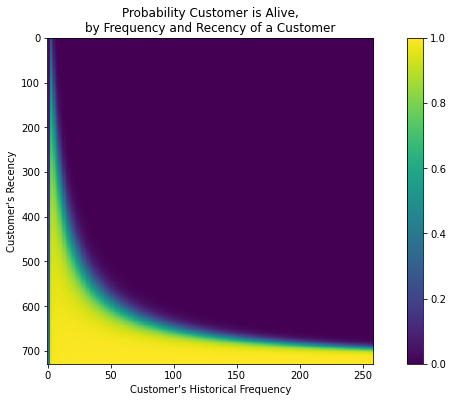

In [292]:
#for two year

plot_probability_alive_matrix(bgf3)

### Findings

There are many findings that have been uncovered in the process of this analysis. 

One finding was the difference in survival rates between Brixc's products. There was a big difference in the velocity of decline between the \\$19 and \\$79 option. This decline is much more evident in the legacy products than that of the new ones. What could this possibly mean? Perhaps, there's less differentiation between newer products.

Another finding that was discovered in the analysis of this project was Brixc's Customers Lifetime Value. We can see that the distribution of the Customer Lifetime Values values are heavily skewed and that most of the values lie between \\$1-\\$10.

One finding that found was with the Probability Customer is Alive plot that showed us that there was much uncertainty with regards to the probability of whether a customer was alive or not (in the all years plot). It also revealed that only after 400 time period (days) did the frequency start to increase.   


### Limitations of Analysis

- There was no overarching goal in the brief but rather separate direct questions and as a result the anlysis and report felt disjointed and broad. 

- Due to the complexity of the dataset and lack of previous analysis, some data values may be misinterpreted. 

- One limitation of the this analysis is the heavy reliance on secondary libraries and modules. I understand that re-invention of the wheel is often not needed, however, perhaps creating models from scratch would be more beneficial for the reader's understanding.

- Because of the novelty of some of the products, it's difficult to gauge the reliability of the results due to the relatively small sample size. Once this sample size increase more reliable trends in the data will be formed. 


### Conclusion and Recommendations

In conclusion, I believe that the questions answered in this analysis are faced by many start-ups and not just Brixc exclusively. Given the results of the analysis I would recommend that the company take a closer look at their pricing strategy and ways to decrease customer churn. Perhaps decreasing the extremities between the prices of different subscription options will increase the average customer transaction value and lower the attrition rate. Also Brixc should also look into ways to increase customer lifetime value, currently the distribution is heavily skewed and most of the values are in the lower quartile ranges.

### Further Research Materials: 

Here are some links that helped during the research component of this project: 

- https://medium.com/bolt-labs/understanding-the-customer-lifetime-value-with-data-science-c14dcafa0364#:~:text=The%20model%20gives%20an%20immediate,model%20(BG%2FNBD).


- https://towardsdatascience.com/data-driven-growth-with-python-part-3-customer-lifetime-value-prediction-6017802f2e0f


- https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444


- https://github.com/kpei/Customer-Analytics/blob/master/customer_zakka.ipynb


- https://en.wikipedia.org/wiki/Survival_analysis#:~:text=Survival%20analysis%20is%20a%20branch,and%20failure%20in%20mechanical%20systems.

